<a href="https://colab.research.google.com/github/shubham13596/Stanford-CS224S/blob/main/Copy_of_CS_224S_HW4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# CS 224S Assignment 4 - Leveraging audio foundation models and working with non-English speech

CS224S / LINGUIST285: Spoken Language Processing. Homework 4

In this assignment, you will use pre-trained foundation models to work with multiple non-English languages. We will use foundation model features to visualize speech data from several languages, and leverage these models to do speech transcription and improve performance without being able to understand each language as we work!

This homework is worth 125 points total and represents 25% of your final grade in the course.

# Part 1: Visualising representations of large pretrained self-supervised speech models (35 points)

Visualizing embedding data can help us understand what deep learning embeddings are encoding about their inputs. Large self-supervised audio models can capture aspects of phonetics, prosody, and speaker characteristics depending on the deep learning architecture and training tasks/data.

In this section we will obtain embedding representations for speech data using a pre-trained model, and then visualize the embedding features to understand what they might encode about our data.

###### Part 1 Imports - run when working on Part 1

In [1]:
!pip install -q -U datasets
!pip install -U -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0

In [2]:
from datasets import load_dataset

import torch
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, AutoTokenizer
import datasets
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


## Extracting Features

With a large pretrained model, you can extract the hidden states of each layer. For models like wav2vec 2.0 with convolutional feature extractors, you can also extract these quantized representations from the model. Below is an example of how to extract features from wav2vec 2.0 XLS-R (300 million paramter model) with the Telugu portion of the FLEURS dataset.

## Load dataset

We start by loading the data from HuggingFace. Here, we load the Telugu test set.

If you get the error below:

```
NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.
```

Click Runtime > Disconnect and delete runtime and try again.

In [4]:
tel_test = load_dataset("google/fleurs", "te_in", split="test[:100]", verification_mode='no_checks', download_mode="force_redownload", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

fleurs.py:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

fleurs.py:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

train.tar.gz:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/167M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/270M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/350k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/566k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Feel free to explore the dataset a bit!

In [5]:
tel_test

Dataset({
    features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
    num_rows: 100
})

## Load pretrained model

We can then do inference with a file from the dataset to have a look at the model outputs. The [documentation](https://huggingface.co/docs/transformers/en/model_doc/wav2vec2#transformers.Wav2Vec2Model.forward) states that the model returns three different types of output:



*   `last_hidden_state` (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) — Sequence of hidden-states at the output of the last layer of the model.
*   `extract_features` (torch.FloatTensor of shape (batch_size, sequence_length, conv_dim[-1])) — Sequence of extracted feature vectors of the last convolutional layer of the model.
*   `hidden_states` (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).


In [6]:
# Uncomment below to run just this cell
import torch
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, AutoTokenizer
import datasets


feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-xls-r-300m").to(device)

dataset = load_dataset("google/fleurs", "te_in", split="train")
dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate=16_000))
dataset_iter = iter(dataset)
sample = next(dataset_iter)

input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt").input_values.to(device)
with torch.no_grad():
  outputs = model(input_values, output_hidden_states=True)
outputs

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


Wav2Vec2BaseModelOutput(last_hidden_state=tensor([[[-0.2733, -0.0265, -0.1297,  ..., -0.0705, -0.0219,  0.0628],
         [ 0.1376,  0.0759,  0.0409,  ..., -0.0835,  0.0302,  0.5203],
         [ 0.1743,  0.0907,  0.0691,  ..., -0.0851,  0.0291,  0.5290],
         ...,
         [ 0.1715,  0.0964,  0.0635,  ..., -0.1003,  0.0369,  0.5260],
         [ 0.0942,  0.0754,  0.0182,  ..., -0.1029,  0.0371,  0.3982],
         [-0.2025,  0.0185, -0.1250,  ..., -0.0126, -0.0183,  0.2122]]],
       device='cuda:0'), extract_features=tensor([[[-1.9042, -0.0619, -3.5601,  ..., -1.2402,  0.3889,  0.9159],
         [-1.9042, -0.0619, -3.5601,  ..., -1.2402,  0.3889,  0.9159],
         [-1.9042, -0.0619, -3.5601,  ..., -1.2402,  0.3889,  0.9159],
         ...,
         [-1.9042, -0.0619, -3.5601,  ..., -1.2402,  0.3889,  0.9159],
         [-1.9042, -0.0619, -3.5601,  ..., -1.2402,  0.3889,  0.9159],
         [-1.9042, -0.0619, -3.5601,  ..., -1.2402,  0.3889,  0.9159]]],
       device='cuda:0'), hidden_

## Run inference and extract embedding features from model

We can now extract model outputs for 50 examples in the dataset.



In [20]:
# Uncomment below to run just this cell
# import itertools
# import torch
# import numpy as np

dataset = tel_test.cast_column("audio", datasets.Audio(sampling_rate=16_000))
dataset_iter = iter(dataset)
feats = []
for sample in itertools.islice(dataset_iter, 2):
  input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  outputs = model(input_values, output_hidden_states=True)
  current_output = outputs['extract_features']
  feats.append(torch.mean(current_output, 1, True).cpu().detach().numpy())

all_feats = np.hstack(feats).squeeze()


NameError: name 'feature_extractor' is not defined

## Visualising extracted features with t-SNE

Then we can make a [t-SNE](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) plot of the outputs. This allows use to visualise the embeddings in a two-dimensional space, possibly spotting patterns in the data. We used the seaborn library to make the t-SNE plot.

It is not the only way to visualise embeddings, [UMAP](https://arxiv.org/abs/1802.03426) is also used.

We plot the extracted features below. We do not specify the hue since all the features are from the same language.

We see some slight grouping emegering, but we're not too concerned about this at the moment since we're not clustering by language.

<ipython-input-7-ca12183c2381>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

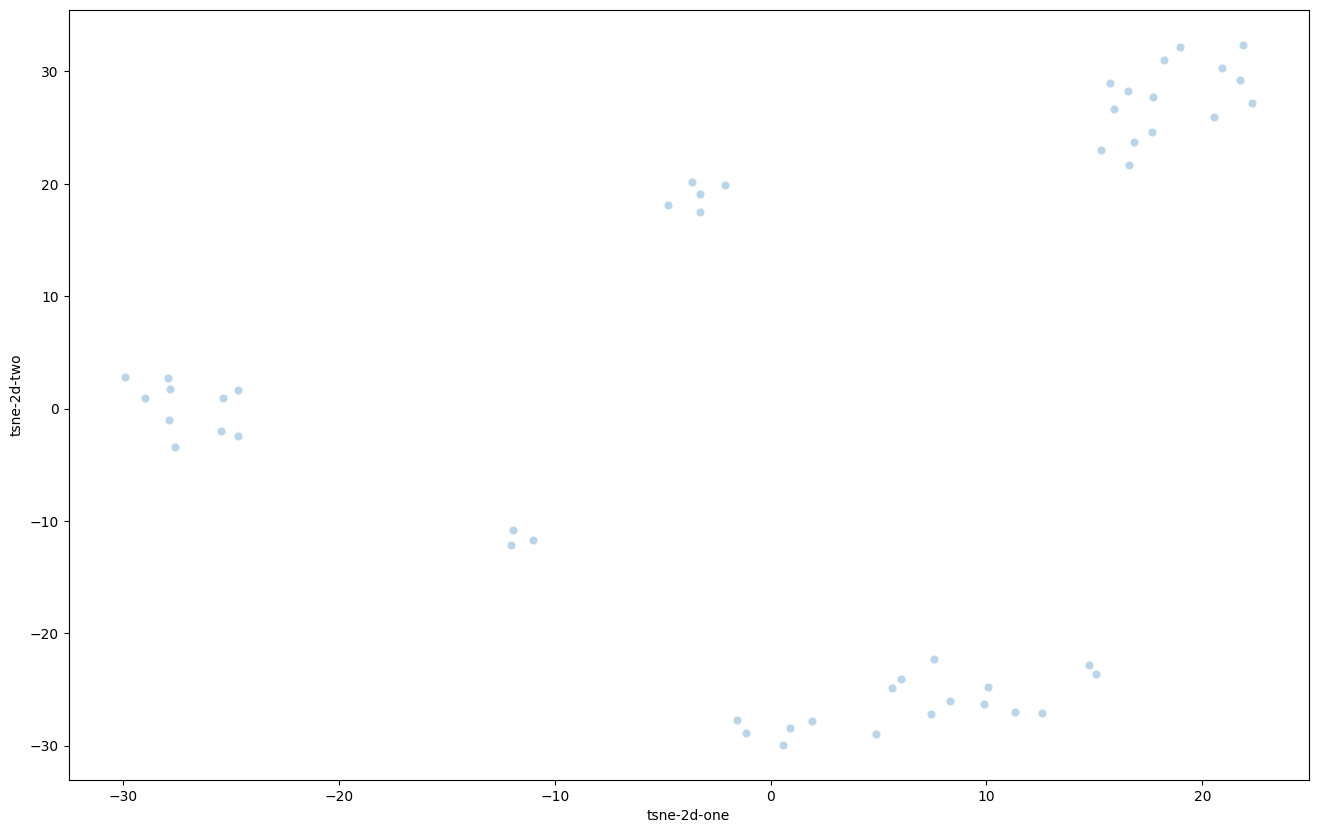

In [7]:
# Uncomment below to run just this cell
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5)
tsne_results = tsne.fit_transform(all_feats)

df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

### Broken t-SNE example

Beware of the "t-SNE sphere" that can result from selecting the wrong hyperparameters or having features that are noisy. Below is an exmaple of a plot with no correlation, which is not very useful.

When building t-SNE plots, you should consider plots with uniform spacing between points as "broken" and try to investigate why t-SNE was unable to find meaningful correlation structure in your dataset

<ipython-input-8-efe7adb53852>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

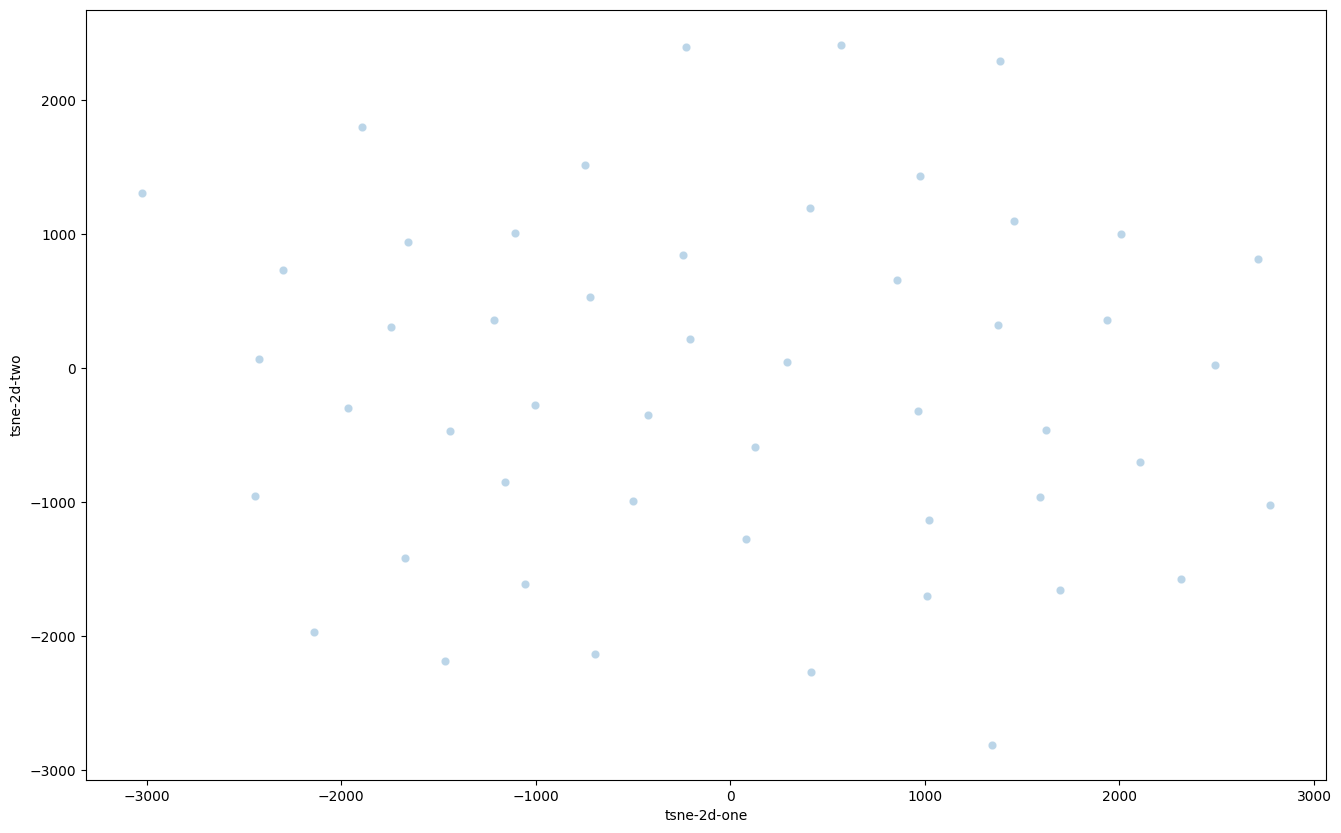

In [8]:
tsne = TSNE(n_components=2, learning_rate=1000,
                  init='random', perplexity=30)
tsne_results = tsne.fit_transform(all_feats)

df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

## 1.3 Plotting low-resource language representations

### 1.3.1 Task: Plotting the output of the final CNN layer. (10 points)

Make a t-SNE plot of the extracted features of 100 utterances of Wolof (`wo_sn`) and isiZulu (`zu_za`) from FLEURs. Give the representations of each language a different color or point type. What do you notice about this plot? Why do you think this pattern exists?

**Deliverable:** t-SNE plot and one parapraph detailing your findings.

In [13]:
#############################
#### YOUR CODE GOES HERE ####

wolof_dataset = load_dataset("google/fleurs", "wo_sn", split="test")
isi_dataset = load_dataset("google/fleurs", "zu_za", split = "test")

wolof_dataset = wolof_dataset.cast_column("audio", datasets.Audio(sampling_rate = 16000))
isi_dataset = isi_dataset.cast_column("audio", datasets.Audio(sampling_rate = 16000))

wolof_dataset_iter = iter(wolof_dataset)
isi_dataset_iter = iter(isi_dataset)

sample_wolof = next(wolof_dataset_iter)
sample_isi = next(isi_dataset_iter)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-xls-r-300m").to(device)


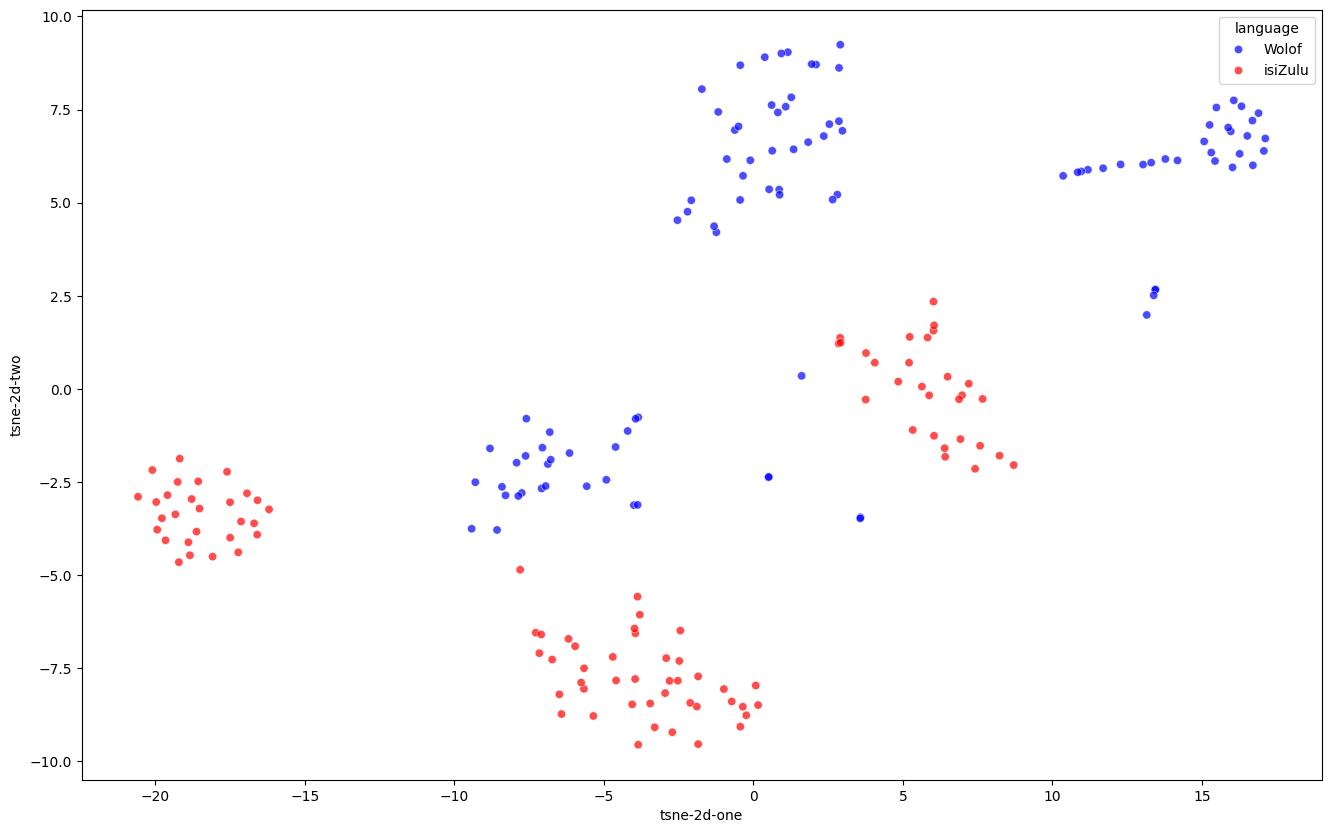

In [9]:
# calculating all_feats_wolof for wolof
feats_wolof = []

for sample_wolof in itertools.islice(wolof_dataset_iter, 100):
  input_values = feature_extractor(sample_wolof["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  current_output = outputs['extract_features']
  feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()

# calculating all_feats_isi for isi
feats_isi = []

for sample_isi in itertools.islice(isi_dataset_iter, 100):
  input_values = feature_extractor(sample_isi["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  current_output = outputs['extract_features']
  feats_isi.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_isi = np.hstack(feats_isi).squeeze()

# Combining samples for both the languages in 1 vector - 200 x dimensions
all_feats = np.vstack([all_feats_wolof, all_feats_isi])
language_labels = ['Wolof'] * len(all_feats_wolof) + ['isiZulu'] * len(all_feats_isi)


# initializing a tsne object
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)

# t-sne plot creation
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="language",  # This colors points by language
    palette={"Wolof": "blue", "isiZulu": "red"},  # Explicitly define color
    data=df,
    legend="full",
    alpha=0.7
)
plt.show()

############################

### 1.3.2 Task: Plotting the last hidden state. (5 points)

For the same language pair (Wolof (`wo_sn`) and isiZulu (`zu_za`)), plot the output of the final hidden state. How does this plot differ from the other plot? Given your knowlege of the difference in the representations, why do you think this is different?

**Deliverable:** t-SNE plot and one parapraph detailing your findings.

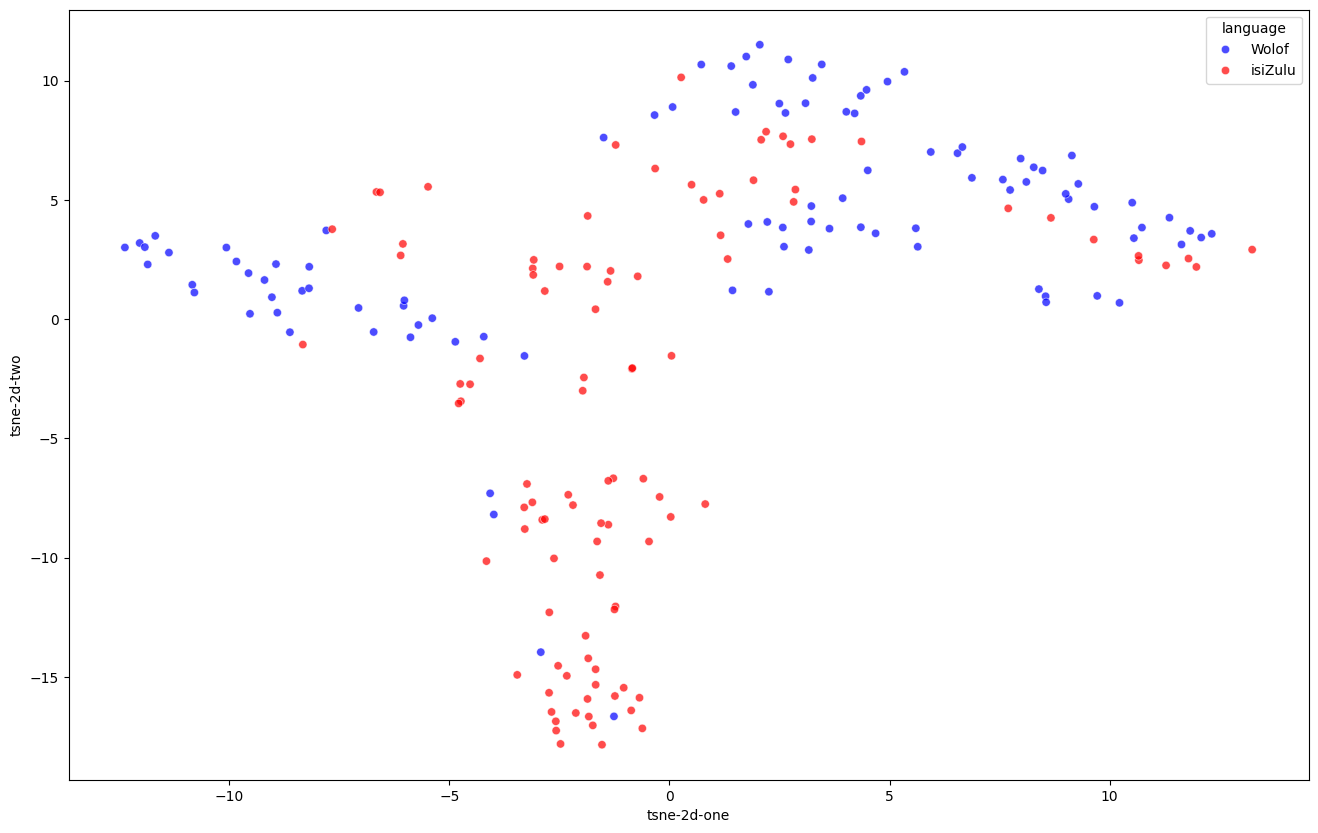

In [14]:
#############################
#### YOUR CODE GOES HERE ####

#PLOTTING FOR LAST HIDDEN STATE

# calculating all_feats_wolof for wolof
feats_wolof = []
for sample_wolof in itertools.islice(wolof_dataset_iter, 100):
  input_values = feature_extractor(sample_wolof["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  current_output = outputs['last_hidden_state']
  feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()


# calculating all_feats_isi for isi
feats_isi = []
for sample_isi in itertools.islice(isi_dataset_iter, 100):
  input_values = feature_extractor(sample_isi["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  current_output = outputs['last_hidden_state']
  feats_isi.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_isi = np.hstack(feats_isi).squeeze()



# Combining samples for both the languages in 1 vector - 200 x dimensions
all_feats = np.vstack([all_feats_wolof, all_feats_isi])
language_labels = ['Wolof'] * len(all_feats_wolof) + ['isiZulu'] * len(all_feats_isi)


# initializing a tsne object
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)

# t-sne plot creation
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="language",  # This colors points by language
    palette={"Wolof": "blue", "isiZulu": "red"},  # Explicitly define color
    data=df,
    legend="full",
    alpha=0.7
)
plt.show()

############################

############################

### 1.3.3 Task: Plot and analyze hidden layer of your choice. (10 points)



Pick a hidden layer that is not the final hidden layer and repeat the plot for the two languages. Why did you pick this layer? Are the respresentations any different? Why or why not?

**Deliverable:** t-SNE plot and one parapraph detailing your findings.

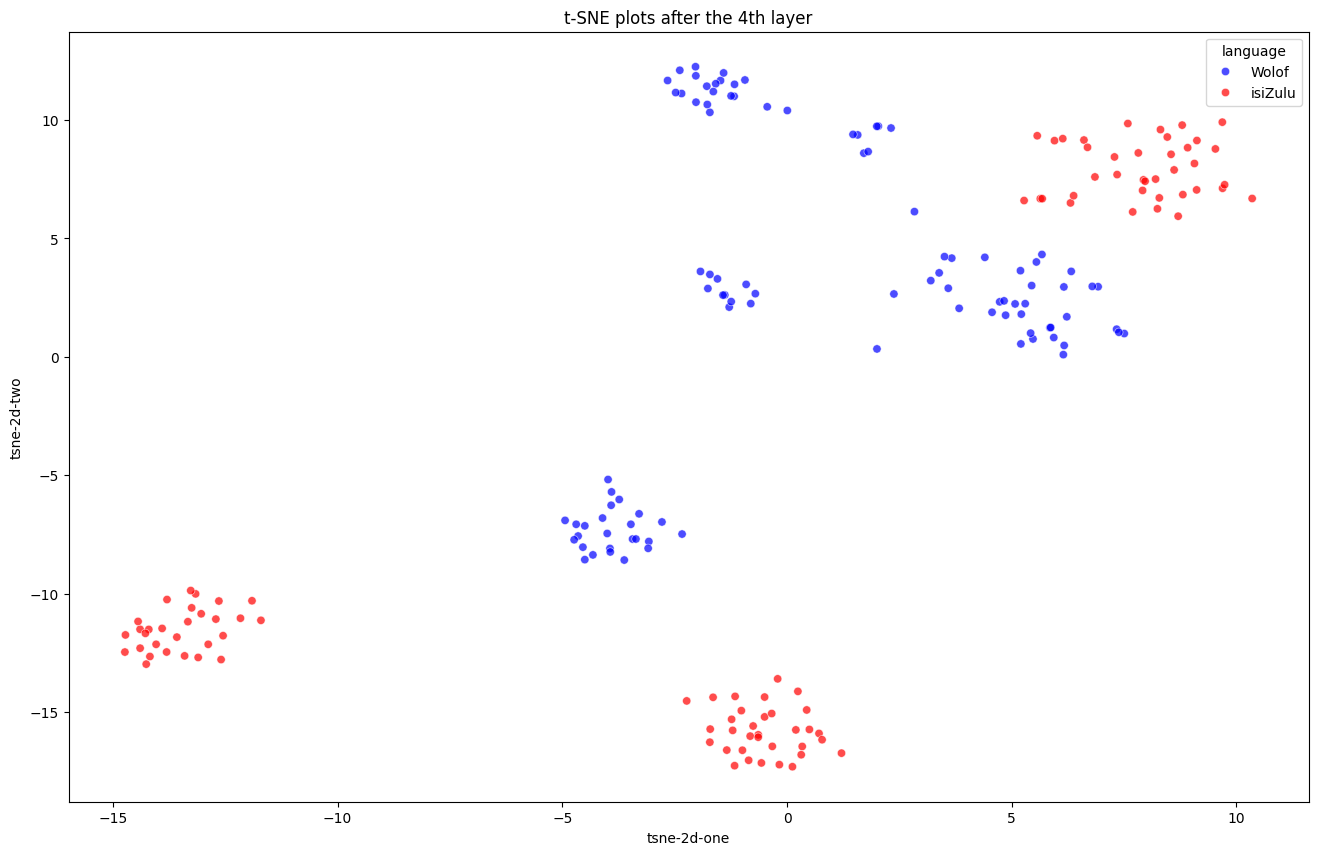

In [15]:
#############################
#### YOUR CODE GOES HERE ####

#PLOTTING FOR THE 4TH HIDDEN LAYER (NOT THE FINAL ONE)

# calculating all_feats_wolof for wolof
feats_wolof = []

for sample_wolof in itertools.islice(wolof_dataset_iter, 100):
  input_values = feature_extractor(sample_wolof["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  # key value changed to last_hidden_state
  current_output = outputs['hidden_states'][3]
  feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()

# calculating all_feats_isi for isi
feats_isi = []

for sample_isi in itertools.islice(isi_dataset_iter, 100):
  input_values = feature_extractor(sample_isi["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  # key value changed to last_hidden_state
  current_output = outputs['hidden_states'][3]
  feats_isi.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_isi = np.hstack(feats_isi).squeeze()

# Combining samples for both the languages in 1 vector - 200 x dimensions
all_feats = np.vstack([all_feats_wolof, all_feats_isi])
language_labels = ['Wolof'] * len(all_feats_wolof) + ['isiZulu'] * len(all_feats_isi)


# initializing a tsne object
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)

# t-sne plot creation
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="language",  # This colors points by language
    palette={"Wolof": "blue", "isiZulu": "red"},  # Explicitly define color
    data=df,
    legend="full",
    alpha=0.7
)
plt.title("t-SNE plots after the 4th layer")
plt.show()



############################

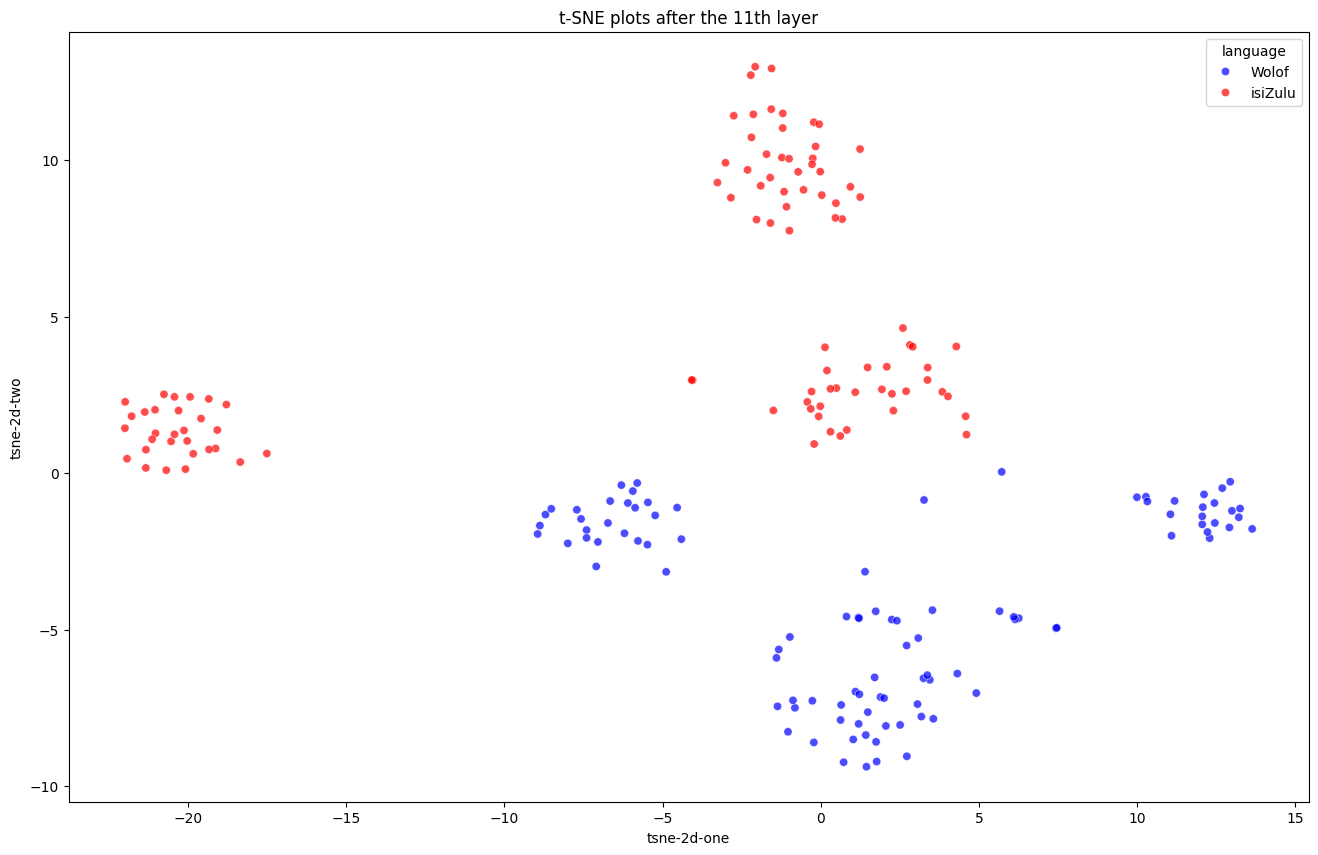

In [16]:
#############################
#### YOUR CODE GOES HERE ####

#PLOTTING FOR THE 11TH HIDDEN LAYER (NOT THE FINAL ONE)

# calculating all_feats_wolof for wolof
feats_wolof = []

for sample_wolof in itertools.islice(wolof_dataset_iter, 100):
  input_values = feature_extractor(sample_wolof["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  # key value changed to last_hidden_state
  current_output = outputs['hidden_states'][10]
  feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()

# calculating all_feats_isi for isi
feats_isi = []

for sample_isi in itertools.islice(isi_dataset_iter, 100):
  input_values = feature_extractor(sample_isi["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
  with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True)
  # key value changed to last_hidden_state
  current_output = outputs['hidden_states'][10]
  feats_isi.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_isi = np.hstack(feats_isi).squeeze()

# Combining samples for both the languages in 1 vector - 200 x dimensions
all_feats = np.vstack([all_feats_wolof, all_feats_isi])
language_labels = ['Wolof'] * len(all_feats_wolof) + ['isiZulu'] * len(all_feats_isi)


# initializing a tsne object
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)

# t-sne plot creation
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="language",  # This colors points by language
    palette={"Wolof": "blue", "isiZulu": "red"},  # Explicitly define color
    data=df,
    legend="full",
    alpha=0.7
)
plt.title("t-SNE plots after the 11th layer")
plt.show()



############################

### 1.3.4 Task: Plotting more languages. (10 points)

Now make a t-SNE plot of representations of 100 utterances of:


*   Kiswahili (`sw_ke`)
*   Bosnian (`bs_ba`)
*   Thai (`th_th`)
*   Wolof (`wo_sn`)
*   Vietnamese (`vi_vn`)

You are free to extract whichever features you like. Try at least two methods and report which one results in the most separation between language clusters. Explain your methods and choice in methods.


**Deliverable:** t-SNE plot, code for each different method attempted along with reasons why you chose the methods. One parapraph detailing your findings.


In [17]:
#############################
#### YOUR CODE GOES HERE ####

kiswahili_dataset = load_dataset("google/fleurs", "sw_ke", split="test")
bosnian_dataset = load_dataset("google/fleurs", "bs_ba", split = "test")
thai_dataset = load_dataset("google/fleurs", "th_th", split = "test")
wolof_dataset = load_dataset("google/fleurs", "wo_sn", split = "test")
vietnamese_dataset = load_dataset("google/fleurs", "vi_vn", split = "test")


# Cast all datasets' audio columns to 16kHz sampling rate
kiswahili_dataset = kiswahili_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
bosnian_dataset = bosnian_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
thai_dataset = thai_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
wolof_dataset = wolof_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
vietnamese_dataset = vietnamese_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))

# Create iterators for all datasets
kiswahili_dataset_iter = iter(kiswahili_dataset)
bosnian_dataset_iter = iter(bosnian_dataset)
thai_dataset_iter = iter(thai_dataset)
wolof_dataset_iter = iter(wolof_dataset)
vietnamese_dataset_iter = iter(vietnamese_dataset)

# Get first sample from each dataset
sample_kiswahili = next(kiswahili_dataset_iter)
sample_bosnian = next(bosnian_dataset_iter)
sample_thai = next(thai_dataset_iter)
sample_wolof = next(wolof_dataset_iter)
sample_vietnamese = next(vietnamese_dataset_iter)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-xls-r-300m").to(device)


############################

train.tar.gz:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/136M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/333M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/116k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/276k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/230M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/540M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/222k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/531k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/593M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/3.08M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/540k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/1.61G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/215M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/544M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/247k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/614k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Processed 100 Kiswahili samples, shape: (100, 512)
Processed 100 Bosnian samples, shape: (100, 512)
Processed 100 Thai samples, shape: (100, 512)
Processed 100 Wolof samples, shape: (100, 512)
Processed 100 Vietnamese samples, shape: (100, 512)


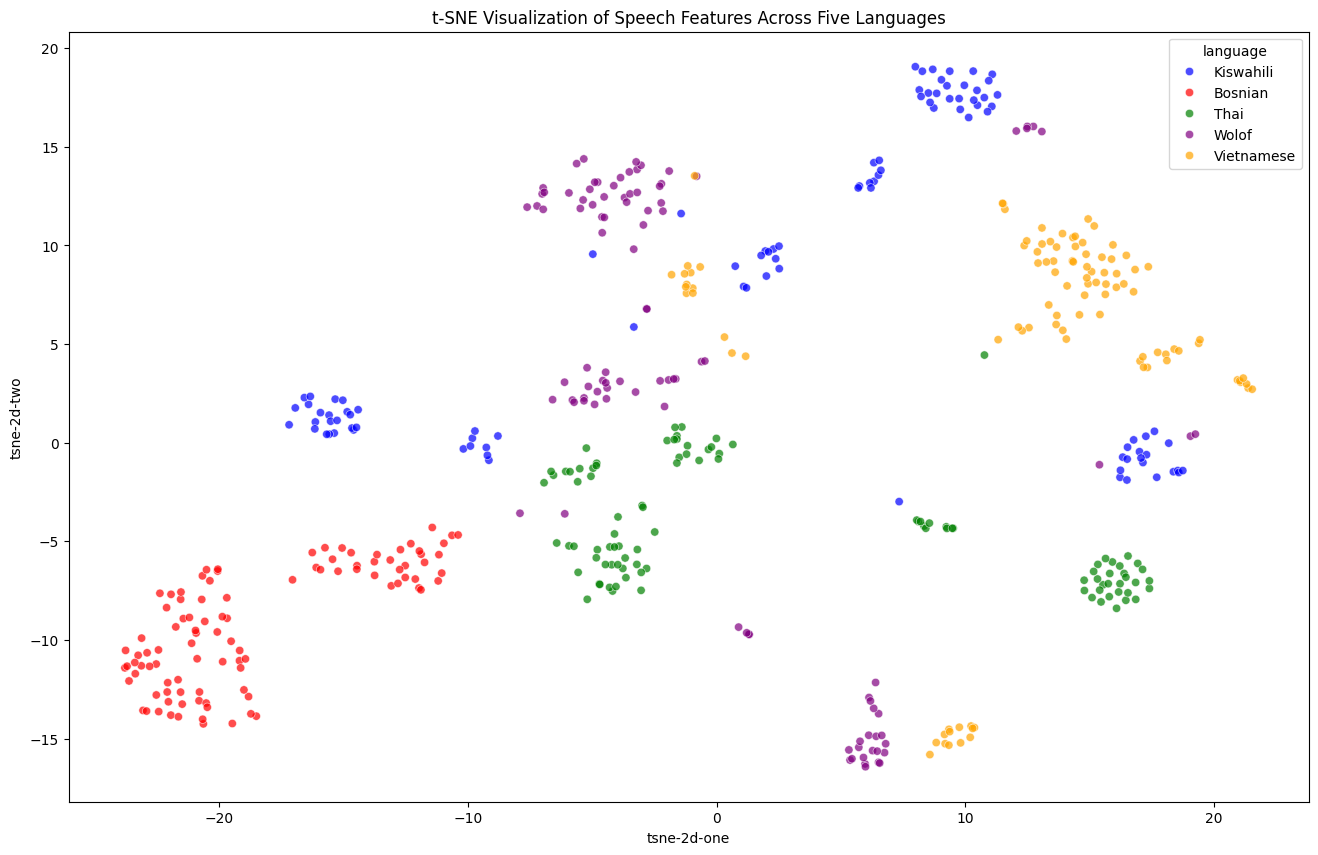

In [18]:
# Calculate features for Kiswahili
feats_kiswahili = []
for sample in itertools.islice(kiswahili_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['extract_features']
    feats_kiswahili.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_kiswahili = np.hstack(feats_kiswahili).squeeze()
print(f"Processed 100 Kiswahili samples, shape: {all_feats_kiswahili.shape}")

# Calculate features for Bosnian
feats_bosnian = []
for sample in itertools.islice(bosnian_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['extract_features']
    feats_bosnian.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_bosnian = np.hstack(feats_bosnian).squeeze()
print(f"Processed 100 Bosnian samples, shape: {all_feats_bosnian.shape}")

# Calculate features for Thai
feats_thai = []
for sample in itertools.islice(thai_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['extract_features']
    feats_thai.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_thai = np.hstack(feats_thai).squeeze()
print(f"Processed 100 Thai samples, shape: {all_feats_thai.shape}")

# Calculate features for Wolof
feats_wolof = []
for sample in itertools.islice(wolof_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['extract_features']
    feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()
print(f"Processed 100 Wolof samples, shape: {all_feats_wolof.shape}")

# Calculate features for Vietnamese
feats_vietnamese = []
for sample in itertools.islice(vietnamese_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['extract_features']
    feats_vietnamese.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_vietnamese = np.hstack(feats_vietnamese).squeeze()
print(f"Processed 100 Vietnamese samples, shape: {all_feats_vietnamese.shape}")

# Combining samples for all languages in 1 vector - 500 x dimensions
all_feats = np.vstack([
    all_feats_kiswahili,
    all_feats_bosnian,
    all_feats_thai,
    all_feats_wolof,
    all_feats_vietnamese
])

# Create language labels
language_labels = (
    ['Kiswahili'] * len(all_feats_kiswahili) +
    ['Bosnian'] * len(all_feats_bosnian) +
    ['Thai'] * len(all_feats_thai) +
    ['Wolof'] * len(all_feats_wolof) +
    ['Vietnamese'] * len(all_feats_vietnamese)
)

# Initialize a t-SNE object (increased perplexity for more samples)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=40)

# Create t-SNE plot
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

# Plot with more distinct colors for 5 languages
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="language",  # Colors points by language
    palette={
        "Kiswahili": "blue",
        "Bosnian": "red",
        "Thai": "green",
        "Wolof": "purple",
        "Vietnamese": "orange"
    },
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Visualization of Extracted Speech Features(after CNNs) Across Five Languages')
plt.show()

Processed 100 Kiswahili samples, shape: (100, 1024)
Processed 100 Bosnian samples, shape: (100, 1024)
Processed 100 Thai samples, shape: (100, 1024)
Processed 100 Wolof samples, shape: (100, 1024)
Processed 100 Vietnamese samples, shape: (100, 1024)


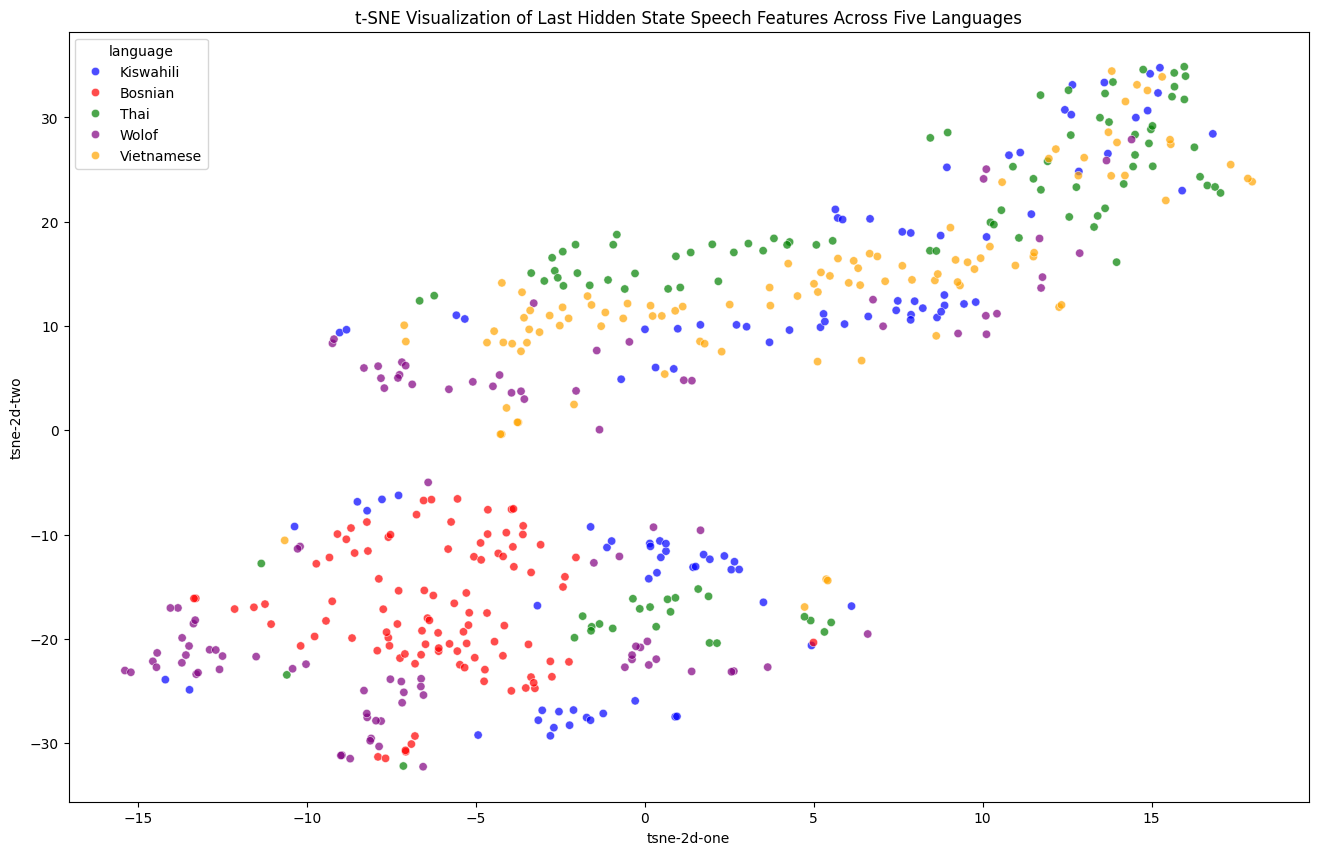

In [19]:
# Calculate features for Kiswahili
feats_kiswahili = []
for sample in itertools.islice(kiswahili_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['last_hidden_state']
    feats_kiswahili.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_kiswahili = np.hstack(feats_kiswahili).squeeze()
print(f"Processed 100 Kiswahili samples, shape: {all_feats_kiswahili.shape}")

# Calculate features for Bosnian
feats_bosnian = []
for sample in itertools.islice(bosnian_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['last_hidden_state']
    feats_bosnian.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_bosnian = np.hstack(feats_bosnian).squeeze()
print(f"Processed 100 Bosnian samples, shape: {all_feats_bosnian.shape}")

# Calculate features for Thai
feats_thai = []
for sample in itertools.islice(thai_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['last_hidden_state']
    feats_thai.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_thai = np.hstack(feats_thai).squeeze()
print(f"Processed 100 Thai samples, shape: {all_feats_thai.shape}")

# Calculate features for Wolof
feats_wolof = []
for sample in itertools.islice(wolof_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['last_hidden_state']
    feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()
print(f"Processed 100 Wolof samples, shape: {all_feats_wolof.shape}")

# Calculate features for Vietnamese
feats_vietnamese = []
for sample in itertools.islice(vietnamese_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['last_hidden_state']
    feats_vietnamese.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_vietnamese = np.hstack(feats_vietnamese).squeeze()
print(f"Processed 100 Vietnamese samples, shape: {all_feats_vietnamese.shape}")

# Combining samples for all languages in 1 vector - 500 x dimensions
all_feats = np.vstack([
    all_feats_kiswahili,
    all_feats_bosnian,
    all_feats_thai,
    all_feats_wolof,
    all_feats_vietnamese
])

# Create language labels
language_labels = (
    ['Kiswahili'] * len(all_feats_kiswahili) +
    ['Bosnian'] * len(all_feats_bosnian) +
    ['Thai'] * len(all_feats_thai) +
    ['Wolof'] * len(all_feats_wolof) +
    ['Vietnamese'] * len(all_feats_vietnamese)
)

# Initialize a t-SNE object (increased perplexity for more samples)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=40)

# Create t-SNE plot
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

# Plot with more distinct colors for 5 languages
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="language",  # Colors points by language
    palette={
        "Kiswahili": "blue",
        "Bosnian": "red",
        "Thai": "green",
        "Wolof": "purple",
        "Vietnamese": "orange"
    },
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Visualization of Last Hidden State Speech Features Across Five Languages')
plt.show()

Processed 100 Kiswahili samples, shape: (100, 1024)
Processed 100 Bosnian samples, shape: (100, 1024)
Processed 100 Thai samples, shape: (100, 1024)
Processed 100 Wolof samples, shape: (100, 1024)
Processed 100 Vietnamese samples, shape: (100, 1024)


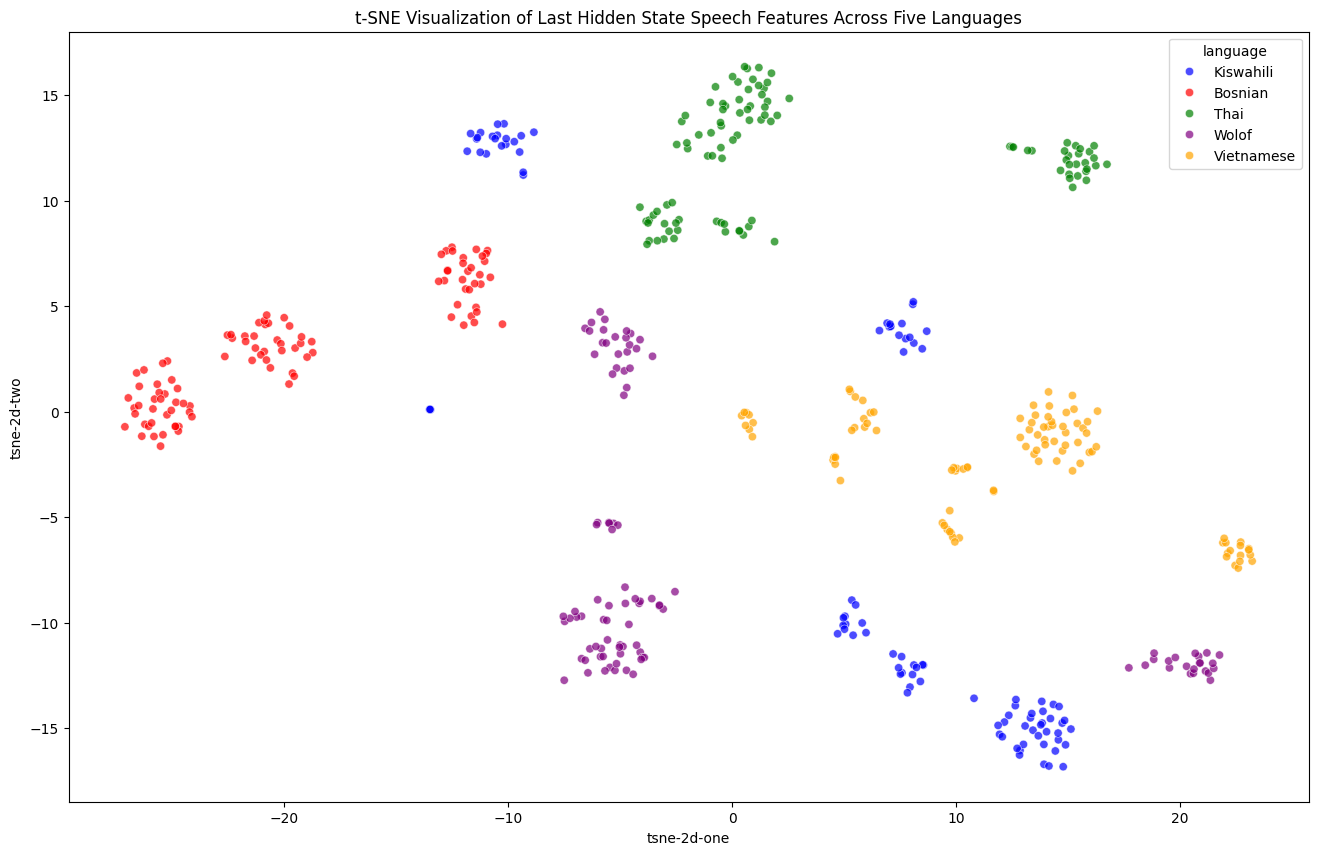

In [20]:
# Calculate features for Kiswahili
feats_kiswahili = []
for sample in itertools.islice(kiswahili_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['hidden_states'][3]
    feats_kiswahili.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_kiswahili = np.hstack(feats_kiswahili).squeeze()
print(f"Processed 100 Kiswahili samples, shape: {all_feats_kiswahili.shape}")

# Calculate features for Bosnian
feats_bosnian = []
for sample in itertools.islice(bosnian_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['hidden_states'][3]
    feats_bosnian.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_bosnian = np.hstack(feats_bosnian).squeeze()
print(f"Processed 100 Bosnian samples, shape: {all_feats_bosnian.shape}")

# Calculate features for Thai
feats_thai = []
for sample in itertools.islice(thai_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['hidden_states'][3]
    feats_thai.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_thai = np.hstack(feats_thai).squeeze()
print(f"Processed 100 Thai samples, shape: {all_feats_thai.shape}")

# Calculate features for Wolof
feats_wolof = []
for sample in itertools.islice(wolof_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['hidden_states'][3]
    feats_wolof.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_wolof = np.hstack(feats_wolof).squeeze()
print(f"Processed 100 Wolof samples, shape: {all_feats_wolof.shape}")

# Calculate features for Vietnamese
feats_vietnamese = []
for sample in itertools.islice(vietnamese_dataset_iter, 100):
    input_values = feature_extractor(sample["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)
    current_output = outputs['hidden_states'][3]
    feats_vietnamese.append(torch.mean(current_output, 1, True).cpu().detach().numpy())
all_feats_vietnamese = np.hstack(feats_vietnamese).squeeze()
print(f"Processed 100 Vietnamese samples, shape: {all_feats_vietnamese.shape}")

# Combining samples for all languages in 1 vector - 500 x dimensions
all_feats = np.vstack([
    all_feats_kiswahili,
    all_feats_bosnian,
    all_feats_thai,
    all_feats_wolof,
    all_feats_vietnamese
])

# Create language labels
language_labels = (
    ['Kiswahili'] * len(all_feats_kiswahili) +
    ['Bosnian'] * len(all_feats_bosnian) +
    ['Thai'] * len(all_feats_thai) +
    ['Wolof'] * len(all_feats_wolof) +
    ['Vietnamese'] * len(all_feats_vietnamese)
)

# Initialize a t-SNE object (increased perplexity for more samples)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=40)

# Create t-SNE plot
tsne_results = tsne.fit_transform(all_feats)
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['language'] = language_labels

# Plot with more distinct colors for 5 languages
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="language",  # Colors points by language
    palette={
        "Kiswahili": "blue",
        "Bosnian": "red",
        "Thai": "green",
        "Wolof": "purple",
        "Vietnamese": "orange"
    },
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Visualization of Last Hidden State Speech Features Across Five Languages')
plt.show()


# Part 2: Non-English ASR (25 points)

In this part of this assignment, you will leverage  large, pretrained speech models of choice to do ASR non-English languages. For this part, are free to use any model available on HuggingFace.


We will be looking at these four languages in this section:


*   Lingala (`ln_cd`)
*   Korean(`ko_kr`)
*   isiXhosa (`xh_za`)
*   isiZulu (`zu_za`)
*   Irish (`ga_ie`)



##### Part 2 imports

In [1]:
!pip install -q evaluate
!pip install -q datasets
!pip install -q jiwer
!pip install -U -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"")
print(f"Using device {device}")

# what needs to be moved - model, input_values

In [2]:
from datasets import load_dataset
from evaluate import evaluator
# Uncomment below to remake the Telugu dataset
tel_test = load_dataset("google/fleurs", "te_in", split="test[:50]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

## Inference example

Below is an example of how to get the WER of a loaded dataset:

This code runs inference with a single model for the test set of a single chosen language. You can use this as a starting point to run inference and evaluations on different models and languages.

You can change the model you evaluate by changing the `model_name` variable.

As an example, we will continue to use the Telugu test set from FLEURS.

In [ ]:
model_name = "AntonyG/fine-tune-wav2vec2-large-xls-r-1b-sw"

# Load data and evaluator
task_evaluator = evaluator("automatic-speech-recognition")
tel_test = load_dataset("google/fleurs", "te_in", split="test[:100]")

# temp fix - from https://github.com/huggingface/evaluate/issues/437
task_evaluator.PIPELINE_KWARGS.pop('truncation', None)
assert 'truncation' not in task_evaluator.PIPELINE_KWARGS

# Compute WER
results = task_evaluator.compute(
    model_or_pipeline=model_name,
    data=tel_test,
    input_column="audio",
    label_column="transcription",
    metric="wer",
)
results

## 2.1 Filter dataset by utterance length

### 2.1.1 Add input length to dataset

 `add_input_length` to adds the length of the utterance to the dataset with the attribute `input_length`.


In [7]:
def add_input_length(batch):
    audio = batch["audio"]

    batch["input_length"] = len(audio["array"]) / audio["sampling_rate"]
    return batch

### 2.1.2 Task: Remove utterances longer than 30 seconds (2 point)

Let's filter out utterances longer than 30 seconds out of the dataset.Write a function called `is_audio_length_in_range` to filters out utterances over 30 seconds using the `input_length` that is now in your dataset.

In [8]:
#############################
#### YOUR CODE GOES HERE ####
def is_audio_length_in_range(input_length):
  if input_length > 30:
    return 0
  else:
    return 1

#############################

In [9]:
tel_test = tel_test.map(add_input_length)
tel_test = tel_test.filter(is_audio_length_in_range, input_columns=["input_length"])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

In [10]:
tel_test

Dataset({
    features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'input_length'],
    num_rows: 99
})

### 2.1.3 Task: Make length-based subsets of the dataset (3 points)

Let's make subsets of the dataset based on utterance length. For these datasets we have three utterance lengths:

*   Short (0-10 seconds)
*   Medium (10 - 16 seconds)
*   Long (16 - 30 seconds)


Write a funntion to turn a dataset into a `small`, `medium`, and `longer` dataset based on the utterance lengths above.

In [13]:
#############################
#### YOUR CODE GOES HERE ####
from datasets import Dataset

def make_utterance_datasets(tel_test):
  """
  Split a dataset into three subsets based on utterance length:
    - Short: 0-10 seconds
    - Medium: 10-16 seconds
    - Long: 16-30 seconds

    Args:
        dataset: A Hugging Face dataset containing audio samples

    Returns:
        Tuple of (small, medium, longer) datasets
  """
  small_samples = []
  medium_samples = []
  longer_samples = []

  for sample in tel_test:
    if sample["input_length"] <= 10:
      small_samples.append(sample)
    elif sample["input_length"] <=16:
      medium_samples.append(sample)
    else:
      longer_samples.append(sample)

  small_dataset = datasets.Dataset.from_dict({
        key: [sample[key] for sample in small_samples]
        for key in tel_test.features
    }) if small_samples else datasets.Dataset.from_dict({})

  medium_dataset = datasets.Dataset.from_dict({
      key: [sample[key] for sample in medium_samples]
      for key in tel_test.features
  }) if medium_samples else datasets.Dataset.from_dict({})

  longer_dataset = datasets.Dataset.from_dict({
      key: [sample[key] for sample in longer_samples]
      for key in tel_test.features
  }) if longer_samples else datasets.Dataset.from_dict({})

  return small_dataset, medium_dataset, longer_dataset
#############################

In [14]:
small, medium, longer = make_utterance_datasets(tel_test)

In [15]:
small, medium, longer

(Dataset({
     features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'input_length'],
     num_rows: 45
 }),
 Dataset({
     features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'input_length'],
     num_rows: 43
 }),
 Dataset({
     features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'input_length'],
     num_rows: 11
 }))

### 2.1.4 Task: Make length-based datasets for our 5 languages (5 points)

Now do this for each of the 5 languages we will be working with:


*   Lingala (`ln_cd`)
*   Korean(`ko_kr`)
*   isiXhosa (`xh_za`)
*   isiZulu (`zu_za`)
*   Irish (`ga_ie`)


Return a `dataset_length_dict` with keys being the lowercase language names and values being `[num_short, num_med, num_long]` utterances per language.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

def length_based_datasets():
  lingala_dataset = load_dataset("google/fleurs", "ln_cd", split = "test[:50]")
  korean_dataset = load_dataset("google/fleurs", "ko_kr", split = "test[:50]")
  isixhosa_dataset = load_dataset("google/fleurs", "xh_za", split = "test[:50]")
  isizulu_dataset = load_dataset("google/fleurs", "zu_za", split = "test[:50]")
  irish_dataset = load_dataset("google/fleurs", "ga_ie", split = "test[:50]")

  dataset_combined = [lingala_dataset, korean_dataset, isixhosa_dataset, isizulu_dataset, irish_dataset]

  for dataset in dataset_combined:
    dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate = 16000))
    dataset = dataset.map(add_input_length)
    dataset = dataset.filter(is_audio_length_in_range, input_columns=["input_length"])

  d_dict = {}
  small, medium, longer = make_utterance_datasets(lingala_dataset)
  d_dict["lingala"] = [len(small), len(medium), len(longer)]

  small, medium, longer = make_utterance_datasets(korean_dataset)
  d_dict["korean"] = [len(small), len(medium), len(longer)]

  small, medium, longer = make_utterance_datasets(isixhosa_dataset)
  d_dict["isixhosa"] = [len(small), len(medium), len(longer)]

  small, medium, longer = make_utterance_datasets(isizulu_dataset)
  d_dict["isizulu"] = [len(small), len(medium), len(longer)]

  small, medium, longer = make_utterance_datasets(irish_dataset)
  d_dict["irish"] = [len(small), len(medium), len(longer)]

  return d_dict

#############################

In [19]:
dataset_length_dict = length_based_datasets()

train.tar.gz:  35%|###5      | 1.77G/5.03G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/197M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/481M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/113k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/266k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/126M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/214M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/125k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/212k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/227M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/557M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/254k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/617k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/267M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/676M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/214k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/534k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

train.tar.gz:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/572M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/234k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/552k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50 [00:00<?, ? examples/s]

KeyError: 'input_length'

### 2.1.5 Sanity check your function

In [17]:
def check(d_dict):
  return d_dict == {'lingala': [27, 153, 260], 'korean': [87, 231, 64], 'isiXhosa': [278, 538, 218], 'irish': [126, 418, 285], 'isiZulu': [97, 383, 342]}


In [18]:
check(dataset_length_dict)

NameError: name 'dataset_length_dict' is not defined

## 2.2 Task: Compute aggregate word error rate across several languages and utterance lengths (15 points)



Compute the word error rate of the test set for each of these languages across different utterance lengths.

Utterance lengths:


*   Short (0-10 seconds)
*   Medium (10 - 16 seconds)
*   Long (16 - 30 seconds)

Languages:

*   Lingala (`ln_cd`)
*   Korean(`ko_kr`)
*   isiXhosa (`xh_za`)
*   isiZulu (`zu_za`)
*   Irish (`ga_ie`)


Start with MMS 1B `facebook/mms-1b-all` and see if you can find a better model that reduces the WER on medium length utterances across all languages.


We would like a table of WER by utterance length per language for at least two publicly available models.

### Step-by-step guide to 2.2
For those who find it helpful, here is a **step-by-step guide** to creating a basic code block that runs:

**1 Environment preparation**
Start each session by making sure you have a GPU runtime and modern libraries.

* Upgrade the core stack via !pip install -U "transformers>=4.40" sentencepiece soundfile

* Restart the runtime so the new version of transformers is picked up.

* Authenticate once per runtime if you plan on touching Common Voice or gated MMS files:
  from huggingface_hub import login → paste your write token.

**2 Pull the FLEURS test split and attach duration**
For each target language code (e.g. ln_cd for Lingala)

1. Load the "test" split.

2. Immediately cast the audio column to a 16 kHz sampling rate – MMS assumes that rate.

3. Compute a dur field in seconds (len(array) / sampling_rate) via .map.

That dataset object will be reused for every model and length bucket.

*Gotcha*: forgetting the Audio(sampling_rate=16_000) cast will silently resample at runtime and make you wait forever.

**3 Duration buckets**
Use duration buckets you have created above.

**4 ASR pipelines**
**4 ASR pipeline (facebook/mms-1b-all)**
To create a working pipeline:

Load facebook/mms-1b-all with target_lang=<ISO-639-3> via AutoProcessor + AutoModelForCTC; then build a pipeline with the returned tokenizer, feature extractor and model.

Debug checklist

* If every WER is ~1.0 you probably forgot to pass target_lang when loading facebook/mms-1b-all.

**5 Batch inference and WER**
Inside the double-for-loop language × duration-bin:

1. Call the pipeline on bucket["audio"] with a modest batch size (8 fits into a 12 GB V100).

2. Lower-case both hypotheses and references before computing WER via evaluate.load("wer").

3. Append a record {language, len_bin, model, WER} to a running Python list.

Print progress as you go so you can see which combination is slow or failing.

**6 Pivot and inspect**
After the loops finish, convert the list into a pandas.DataFrame and call


df.pivot_table(values="WER",
               index=["language", "len_bin"]).sort_index()

That single line produces exactly the table the graders expect: one row per language-bin, one column per model, lower = better.

**7 Typical outcomes & interpretation**
* MMS-1B-all plus the correct adapter yields WER ≈ 0.20 – 0.40 on these languages.

* The assignment asks you to beat MMS on the medium bucket → obvious next step is to swap in language-specific MMS checkpoints or a community fine-tune.

Use those observations, not my numbers, when you write your reflection.

**8 Trouble-shooting cheatsheet**

* Endless download loops → nuke the faulty cache folder under ~/.cache/huggingface/hub and re-run.

* Runtime slows to a crawl → confirm the “Device set to use cuda:0” banner; Colab occasionally drops back to CPU.

* Tokenizer error on MMS after a restart → recreate the temp vocab; the directory is ephemeral.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
#############################

model_name = "AntonyG/fine-tune-wav2vec2-large-xls-r-1b-sw"

# Load data and evaluator
task_evaluator = evaluator("automatic-speech-recognition")

# temp fix - from https://github.com/huggingface/evaluate/issues/437
task_evaluator.PIPELINE_KWARGS.pop('truncation', None)
assert 'truncation' not in task_evaluator.PIPELINE_KWARGS

# Compute WER
results = task_evaluator.compute(
    model_or_pipeline=model_name,
    data=tel_test,
    input_column="audio",
    label_column="transcription",
    metric="wer",
)
results






#############################

# Part 3: Fine tuning wav2vec2 with isiZulu FLEURS data (65 points)

In this section, you are tasked with improving the word error rate of a finetuned checkpoont on isiZulu FLEURS data. We will start by setting up a training pipeline, do inference with a pretrained checkpoint and then improve the model's performance with different methods.

#### Part 3 imports

In [ ]:
!pip install -q evaluate

In [ ]:
from evaluate import load
import pandas as pd
from transformers import Wav2Vec2ForCTC
from datasets import load_dataset


Now let's build a training pipeline for fine tuning. First we must load and prepare the dataset, then specify some experiment setup to load a model checkpoint and train it while measuring progress.

- Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.

- Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric. We need to define a `compute_metrics` function that handles this computation.

- Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.

- Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule.
We will first start by writing code that converts an audio to melspectogram features that out model can understand

### 3.1 Download the dataset

In [ ]:
train_set = load_dataset("google/fleurs", "zu_za", split="train")
train_set.remove_columns(['id', 'num_samples', 'path', 'raw_transcription',  'gender', 'lang_id', 'language', 'lang_group_id'])
train_set.cast_column("audio", Audio(sampling_rate=16_000))
val_set = load_dataset("google/fleurs", "zu_za", split="validation")
val_set.remove_columns(['id', 'num_samples', 'path', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'])
val_set.cast_column("audio", Audio(sampling_rate=16_000))

### 3.2 Prepare dataset for CTC finetuning

#### 3.2.1 **Task: Remove special characters (5 points)**

As we're doing CTC finetuning, we want to normalise the transcriptions to have a vocabulary that predicts characters that can be associated with a sound. The FLEURS dataset already does this with the `trasncription` column, but we can normalise further by remove special characters.

Write code to remove special characters from the `transcription` column of the dataset.

In [ ]:
import re

#############################
#### YOUR CODE GOES HERE ####




#############################

In [ ]:
train_set = train_set.map(remove_special_characters)
val_set = val_set.map(remove_special_characters)

### 3.3 Making the vocublary and tokenizer



Let's use our transcriptions to make a character vocabulary of the dataset. We store all unqiue characters in a dictionary and add the `[UNK]` and `[PAD]` token. We also replace whitespace with a word spearator token `|`.

In [ ]:
# Extract all chars separately
all_text = " ".join(train_set["transcription"])
vocab = list(set(all_text))

vocab_dict = {v: k for k, v in enumerate(sorted(vocab))}
# vocab_dict # Feel free to print this

# Replace space with |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

# Add [UNK] and [PAD] tokens
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
# len(vocab_dict) #Feel free to check length of vocab

In [ ]:
# Save vocab locally
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./vocab.json",
                                                 unk_token="[UNK]",
                                                 pad_token="[PAD]",
                                                 word_delimiter_token="|")

### 3.4 Create Tokenizer and Feature Extractor

A XLSR-Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLSR-Wav2Vec2 models should **always** make use of the `attention_mask`.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,
                                             sampling_rate=16000,
                                             padding_value=0.0,
                                             do_normalize=True,
                                             return_attention_mask=True)

# A processor wraps a feature extrator and tokenizer into one
processor = Wav2Vec2Processor(feature_extractor=feature_extractor,
                              tokenizer=tokenizer)


### 3.5 Prepare dataset for training

Here, we prepare the dataset for training.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. In our case, this includes only normalization, but for other speech models, this step could correspond to extracting, *e.g.* [Log-Mel features](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # Feature extraction
    inputs = processor.feature_extractor(
        [a["array"] for a in audio],  # list of arrays
        sampling_rate=audio[0]["sampling_rate"],
        return_tensors="np"
    )

    batch["input_values"] = [x for x in inputs["input_values"]]
    batch["input_length"] = [len(x) for x in batch["input_values"]]

    # Tokenize transcriptions
    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids

    return batch

In [ ]:
train_set_training = train_set.map(prepare_dataset, batched=True,  batch_size=16,
    num_proc=1,
    load_from_cache_file=True,
    desc="Preprocessing audio dataset",
)
train_set_training.save_to_disk("preprocessed_train")
val_set_training = val_set.map(prepare_dataset, batched=True, batch_size=16,
    num_proc=1,
    load_from_cache_file=True,
    desc="Preprocessing audio dataset")
val_set_training.save_to_disk("preprocessed_val")

## 3.6 Define a Data Collator

The data collator for a CTC speech model is unique in the sense that it
treats the `input_features` and `labels` independently: the  `input_features` must be
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens
are then replaced by `-100` so that these tokens are **not** taken into account when
computing the loss. We then cut the BOS token from the start of the label sequence as we
append it later during training.


In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


Let's initialise the data collator we've just defined:

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

## 3.7 Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer).

In [ ]:
!pip install -q jiwer
import evaluate

metric = evaluate.load("wer")

### WER metric code for training



This function, called `compute_metrics`, does the following:
1. Replaces `-100` with the `pad_token_id` in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss)
2. Decodes the predicted and label ids to strings.
3. Computes WER between the predictions and reference labels.

Here, we have the option of evaluating with the 'normalised' transcriptions
and predictions. We recommend you set this to `True` to benefit from the WER
improvement obtained by normalising the transcriptions (this ignores casing and punctuation differences)

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids


    label_str = [] # List(str)
    pred_str = [] # List (str)

    # ── undo the -100 mask used in the data-collator
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # ── greedy-decode to strings
    pred_str  = processor.batch_decode(pred_ids,  skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # ── normalise case / punctuation (optional but helps)
    pred_str  = [s.lower().strip() for s in pred_str]
    label_str = [s.lower().strip() for s in label_str]

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer":wer}

## 3.8 Load pretrained checkpoint

Download [the checkpoint linked here](ttps://drive.google.com/drive/folders/1tnXXS5oJaa9ORzfofZ6SVjC6-TCqvrh2?usp=drive_link) and upload it to your Drive. Now you can load the model trained on isiZulu FLEURS data.

In [ ]:
from pathlib import Path
import re
from google.colab import drive
from transformers import Wav2Vec2ForCTC

# Mount Drive once per session (skip if already mounted)
if not Path("/content/drive").is_dir():
    drive.mount("/content/drive")

# Copy checkpoint from Google Drive into your own Google Drive
# Checkpoint dir -> https://drive.google.com/drive/folders/1tnXXS5oJaa9ORzfofZ6SVjC6-TCqvrh2?usp=drive_link

# Folder in Drive where Trainer saves checkpoints
CKPT_DIR = "/content/drive/MyDrive/cs224s_hw4_checkpoints/xls-r-300m-ft-zulu"  # ← change if used another path

# Locate the latest “checkpoint-####” directory
ckpts = sorted(
    Path(CKPT_DIR).glob("checkpoint-*"),
    key=lambda p: int(re.search(r"\d+$", p.name).group()) if re.search(r"\d+$", p.name) else -1
)

# Load model
if ckpts:
    latest = ckpts[-1]
    print(f"Loading checkpoint from {latest}")
    model = Wav2Vec2ForCTC.from_pretrained(
        latest,
    )
else:
    print("No checkpoint found – using base XLS-R model")
    model = Wav2Vec2ForCTC.from_pretrained(
        "facebook/wav2vec2-xls-r-300m",
        pad_token_id=processor.tokenizer.pad_token_id,
        vocab_size=len(processor.tokenizer),
    )

model.freeze_feature_extractor()

print("Model loaded!")

## 3.9 Analyzing the fine tuned model



### 3.9.1 Task: Calculate WER using the provided checkpoint (3 points)

Compute and report WER on the test set with our checkpoint. You should expect a WER of 55.9%.

Fill in the code below, your output format should match the following
```
wer: 0.5587
```

In [ ]:
!pip install -U datasets
!pip install evaluate
!pip install jiwer

In [ ]:
# Run inference with finetuned wav2vec 2.0 to produce transcripts
# Compute WER of the model outputs compared to ground truth

#############################
#### YOUR CODE GOES HERE ####

#############################

3.9.2 Task: Deeper Analysis of Transcriptions (4 points)

For each utterance, compute the WER and CER. Save the results in a dataframe with columns:

* Reference
* Hypothesis
* Input length
* WER
* CER

Feel free to save the dataframe for further analysis. Print the head of the dataframe with `df.head()`

In [ ]:
#############################
#### YOUR CODE GOES HERE ####




#############################
df.head()


#### 3.9.3 Task: Correlation between error and input length (2 points)

Use the pandas `df.corr()` method to compute the correlation between the WER and CER with input length. Write down the WER and CER correlations in the cell below.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

```
correlation between wer and input length:
correlation between cer and input length:
```

**Why do you think you get this correlation?**

Answer the question here.

## 3.10 Improve the model! (55 points)

Now that we have finetuned the model for isiZulu with wav2vec2, let's find ways to improve the word error rate even further.

**You are limited to either using the provided checkpoint or its base model `facebook/wav2vec2-xls-r-300m`. You are also limited to the data of the FLEURS dataset.**

You should expect to get a WER of less than 30%.

You can consider:

*   Increasing your training data
*   Incoporating a (large or small) language model to improve performance
*   Doing LLM-based rescoring
*   Examine the current errors the checkpoint makes and come up with ways to fix them.
---

The three students with the lowest WER will get full credit (55 points). Credit is capped at 50 for submission without the lowest WER.

---

**Results to report for this section**

A summary of the methods you tried, the corresponding WER you get across utterance lengths for each method and for each individual language. Paragraph detailing why you think your method resulting in the lowest averge WER is the best.

We would like to see code of how you would run end-to-end transcription with your new method.


## Appendix: How we trained the baseline

## Define the Training Configuration

In the final step, we define all the parameters related to training.For more detail on the training arguments.

Here you can play around with the training parameters. We have provided default values for you. The default values provided should work well enough, but you are welcome to adjust hyperparameters to obtain better performance.

In [ ]:
!pip install -q wandb

In [ ]:
import wandb
wandb.init(project="224s-hw4")


In [ ]:
from transformers import TrainingArguments

output_dir = "/content/drive/MyDrive/cs224s_hw4_checkpoints/xls-r-300m-ft-zulu/" # Drive outout dir

training_args = TrainingArguments(
  output_dir=output_dir,
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=4,
  eval_strategy="steps",
  num_train_epochs=60,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=400,
  eval_steps=400,
  logging_steps=10,
  learning_rate=3e-5,
  warmup_steps=50,
  save_total_limit=2,
  report_to="wandb",
  load_best_model_at_end=True,
  metric_for_best_model="wer",
  greater_is_better=False,
  push_to_hub=False,
  disable_tqdm=False,
  logging_first_step=True,
)

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator, `compute_metrics` function and custom callback:

In [ ]:
from transformers import Trainer
from datasets import load_from_disk

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_set_training,
    eval_dataset=val_set_training,
    tokenizer=processor.feature_extractor,
)

We'll save the model and processor to the output directory before training:

In [ ]:
model.save_pretrained(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

In [ ]:
# @title
print("Starting training!")
%xmode verbose

trainer.train()

If you need more pointers on training, have a look at the [HuggingFace tutorial](https://https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_Tune_XLSR_Wav2Vec2_on_Turkish_ASR_with_%F0%9F%A4%97_Transformers.ipynb#scrollTo=M9teZcSwOBJ4) that the training code is inspired by.